## Specifications of Original Data
Each .mat file has a four-way tensor electroencephalogram (EEG) data for each subject. 
Please see the reference paper for the detail.

size(eeg) = [Num. of targets, 
Num. of channels, 
Num. of sampling points, 
Num. of trials]

Num. of Targets 	: 12

Num. of Channels 	: 8

Num. of sampling points : 1114

Num. of trials 		: 15


Sampling rate 		: 256 Hz
* The order of the stimulus frequencies in the EEG data: 
[9.25, 11.25, 13.25, 9.75, 11.75, 13.75, 10.25, 12.25, 14.25, 10.75, 12.75, 14.75] Hz
(e.g., eeg(1,:,:,:) and eeg(5,:,:,:) are the EEG data while a subject was gazing at the visual stimuli flickering at 9.25 Hz and 11.75Hz, respectively.)
* The onset of visual stimulation is at 39th sample point.

Reference:
Masaki Nakanishi, Yijun Wang, Yu-Te Wang and Tzyy-Ping Jung,
"A Comparison Study of Canonical Correlation Analysis Based Methods for Detecting Steady-State Visual Evoked Potentials,"
PLoS One, vol.10, no.10, e140703, 2015.

Channel Locations
![image.png](attachment:image.png)

### Standard Imports and Initialization of Helper Functions

In [5]:
                                                                                                                                                                                                                                                           from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!pip install mne

In [7]:
#Standard imports
import matplotlib
import scipy.io as sio
# from filt_tools import butter_bandpass_filter, butter_notch_filter
from scipy.signal import welch
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
import scipy.signal as signal
from scipy.signal import butter, lfilter, iirnotch
from scipy.fft import fft, fftfreq, ifft
import mne
import tensorflow.keras.backend as K
import datetime
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
import numpy as np
from tensorflow import keras
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [10]:
def norm_stand_data(X,max=1,min=0):
  # print("data shape:",X.min(axis=1).shape)
  X_std = (X - X.min(axis=2,keepdims=True)) / (X.max(axis=2,keepdims=True) - X.min(axis=2,keepdims=True))
  X_scaled = X_std * (max - min) + min
  # print("Scale: ",(X_scaled.max(axis=2)-X_scaled.min(axis=2)))
  return X_scaled

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
  nyq = 0.5 * fs
  low = lowcut / nyq
  high = highcut / nyq
  b, a = butter(order, [low, high], btype='band')
  y = lfilter(b, a, data)
  return y

def butter_notch_filter(data,freq,fs,order=5):
  nyq = 0.5 * fs
  target_freq = freq/nyq
  b, a = iirnotch(target_freq,Q=30) #Q=30 is a high quality factor
  y = lfilter(b,a,data)
  return y

def raw_psd_plot(eeg_transformed,freq_label,do_filt=False,
                stim_freq = {1:9.25,2:11.25,3:13.25,4:9.75,5:11.75,6:13.75,7:10.25,8:12.25,9:14.25,10:10.75,11:12.75,12:14.75},
                chan_names = ["PO7","PO3","POz","PO4","PO8","O1","Oz","O2"],
                chan_color = {0: u'orchid', 1: u'darkcyan', 2: u'grey', 
                              3: u'dodgerblue', 4: u'turquoise', 5: u'darkviolet',
                              6: u'firebrick',7:u'red'}
                ):
  if type(eeg_transformed) != np.ndarray: #convert tf. to np.
    eeg_plot = eeg_transformed.numpy()[0,:,:]
  else:
    eeg_plot = eeg_transformed
  
  if do_filt:
    eeg_plot = butter_bandpass_filter(eeg_plot, 7, 60, fs=256, order=2)
  
  #Plot PSD
  plt.figure()
  for i in range(eeg_plot.shape[0]):
    plt.plot(eeg_plot[i,:],label=chan_names[i],color=chan_color[i])
  plt.title(f'Raw {stim_freq[freq_label]}')
  plt.legend()
  df_freq ,df_psd = welch(eeg_plot,fs=256)
  plt.figure()
  for i in range(eeg_plot.shape[0]):
    plt.plot(df_freq,df_psd[i,:],label=chan_names[i],color=chan_color[i])
  plt.vlines(float(stim_freq[freq_label]),ymin=np.min(df_psd), ymax=np.max(df_psd),colors='k')
  plt.legend()
  plt.title(f'PSD {stim_freq[freq_label]}')
  plt.xlim([7,30])
  plt.legend()

def psd_headplotter(spectrum_vals,title="Loss Score Accross Channels"):
  chan_names = ["PO7","PO3","POz","PO4","PO8","O1","Oz","O2"]
  ch_types = ['eeg'] * len(chan_names)
  custom_montage = mne.channels.make_standard_montage('standard_1005')

  sfreq = 256
  info = mne.create_info(ch_names=chan_names, sfreq=sfreq, ch_types=ch_types)
  info.set_montage(custom_montage)
  fig,(ax1) = plt.subplots()
  im,cm   = mne.viz.plot_topomap(spectrum_vals, info, axes=ax1,show=False,vmin=np.min(spectrum_vals),
                                 vmax=np.max(spectrum_vals),names=chan_names,show_names=True)    
  # manually fiddle the position of colorbar
  ax_x_start = 0.80
  ax_x_width = 0.04
  ax_y_start = 0.1
  ax_y_height = 0.8
  cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
  clb = fig.colorbar(im, cax=cbar_ax)
  ax1.set_title(title,fontsize=12)

In [11]:
from sklearn.cross_decomposition import CCA

def CCA_accuracy_assess(X_test,marker_labels,
                        freq_list =  [9.25, 11.25, 13.25, 9.75, 11.75, 13.75, 10.25, 12.25, 14.25, 10.75, 12.75, 14.75],
                        full_output = False):
    sfreq = 256

    WINDOW_SIZE = X_test.shape[-1]
    Y_f = [] #Sinusoids generated to run CCA

    for f in freq_list:
        Y_fsin = np.sin([2*np.pi*f*n/sfreq for n in range(WINDOW_SIZE)])
        Y_fsin2 = np.sin([2*np.pi*(2*f)*n/sfreq for n in range(WINDOW_SIZE)])
        Y_fcos = np.cos([2*np.pi*f*n/sfreq for n in range(WINDOW_SIZE)])
        Y_fcos2 = np.cos([2*np.pi*(2*f)*n/sfreq for n in range(WINDOW_SIZE)])
        Y_f.append(np.vstack([Y_fsin,Y_fcos,Y_fsin2,Y_fcos2]).T) #This stimulus already has mean zero, but any other stimulus should as well

    predictions = []

    for i in range(X_test.shape[0]):
        batch = X_test[i,:,:].T
        score_list = []
        for n in range(len(freq_list)):
            cca = CCA(n_components = 1)
            cca.fit(batch,Y_f[n][:,0:2])
            X_c, Y_c = cca.transform(batch, Y_f[n][:,0:2])
            corr1 = np.corrcoef(X_c[:,0],Y_c[:,0])[0,1]
            score_list.append(corr1)
        if full_output:
          predictions.append(score_list)
        else:
          predictions.append(np.argmax(score_list))
    return np.array(predictions)

In [12]:
def eeg_loader_loo(data_path,leave_out,fmin=7,fmax=60,num_wind=2,visualize=True):
    stim_freq = {1:9.25,2:11.25,3:13.25,4:9.75,5:11.75,6:13.75,7:10.25,8:12.25,9:14.25,10:10.75,11:12.75,12:14.75}
    eeg_train = np.zeros((1,8,1114-90))
    def data_transform(eeg_dict):
        #Putting all trails in first dimension:
        eeg_trial = np.zeros((1,8,1114))
        for i in range(eeg_dict['eeg'].shape[-1]):
            eeg_trial = np.vstack((eeg_trial,eeg_dict['eeg'][:,:,:,i]))
        eeg_trial = eeg_trial[1:]

        #Filtering EEG data:
        filt_eeg = np.zeros((1,8,1114-90))
        for i in range(eeg_trial.shape[0]):
            filt_eeg_trial = butter_bandpass_filter(eeg_trial[i:i+1,:,:], fmin, fmax, fs=256, order=2)
            filt_eeg_trial = filt_eeg_trial[:,:,90:]
            filt_eeg_trial = norm_stand_data(filt_eeg_trial)
            filt_eeg = np.vstack((filt_eeg,filt_eeg_trial))
        filt_eeg = filt_eeg[1:]
        return filt_eeg
    
    #Iterate through file to extract each filtered eeg trial
    for file, direct, d in os.walk(data_path):
        for sub_f in d:
            if sub_f.endswith('mat') and sub_f[:-4] != leave_out:
                eeg_dict = sio.loadmat(file + sub_f)
                eeg_train= np.vstack((eeg_train,data_transform(eeg_dict)))
            elif sub_f.endswith('mat'):
                eeg_dict = sio.loadmat(file + sub_f)
                eeg_test = data_transform(eeg_dict)
    eeg_train= eeg_train[1:]
    
    #Split Dataset based on number of time windows
    train_wind_splits = np.split(eeg_train,num_wind,-1)
    eeg_train= np.vstack(train_wind_splits)
    test_wind_splits = np.split(eeg_test,num_wind,-1)
    eeg_test = np.vstack(test_wind_splits)
    # print("New train shape", eeg_train.shape)
    # print("New test shape", eeg_test.shape)
    
    #Create labels, which correspond to the SSVEP frequency of each recording
    y_train = 15*[1,2,3,4,5,6,7,8,9,10,11,12] #labels per participant
    y_train = 9*y_train #labels for all 9 participants
    y_train = 4*y_train #labels for all 1 second time windows
    
    y_test = 15*[1,2,3,4,5,6,7,8,9,10,11,12]
    y_test = 4*y_test
    
    #Randomize order of train and test set
    idx_train = np.random.permutation(eeg_train.shape[0])
#     print(idx_train)
    eeg_train = eeg_train[idx_train,:,:]
    y_train = np.array(y_train)[idx_train]
    
    idx_test = np.random.permutation(eeg_test.shape[0])
#     print(idx_test)
    eeg_test = eeg_test[idx_test,:,:]
    y_test = np.array(y_test)[idx_test]
    
    if visualize == True:
        for i in range(12,eeg_train.shape[0]):
            raw_psd_plot(eeg_train[i,:,:],y_train[i])
            if i >= 24:
                break
    return eeg_train.transpose(0,2,1),eeg_test.transpose(0,2,1),y_train,y_test

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, AveragePooling1D, MaxPooling1D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D, DepthwiseConv1D, SeparableConv1D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K

### Initializations Needed to Train Model

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K

In [20]:
def SSVEPNet(nb_classes, Chans = 8, Samples = 256, 
             dropoutRate = 0.5, kernLength = 64, 
             D = 1, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1   = Input(shape = (Samples, Chans))
    block1       = DepthwiseConv1D(kernLength, use_bias = False, 
                                   depth_multiplier = D,padding='same')(input1)
    block2       = SeparableConv1D(F2,kernLength,
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization()(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling1D(4)(block2)
    block2       = SeparableConv1D(F2,int(kernLength/2),
                                   use_bias = False, padding = 'same')(block2)
    block2       = BatchNormalization()(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling1D(4)(block2)
    block2       = dropoutType(dropoutRate)(block2)
        
    flatten      = Flatten(name = 'flatten')(block2)
    
    dense        = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)
    
    return Model(inputs=input1, outputs=softmax)

In [21]:
def calc_loss(eeg, model, neuron_idx):
  # Pass forward the image through the model to retrieve the activations
  # and compute the loss.

  #Forward pass
  # eeg_batch = tf.expand_dims(eeg, axis=0)
  layer_activations = model(eeg)
  # print("Layer shape",layer_activations.shape)

  #Create label based on neuron_idx, which indicates output frequency
  label = np.zeros_like(layer_activations)
  label[0,neuron_idx] = 1
  label = tf.convert_to_tensor(label)
  # print("Activations: ",layer_activations)
  # print("Labels: ",label)

  #Calculate Crossentropy Loss
  cce = tf.keras.losses.CategoricalCrossentropy()
  loss = cce(label, layer_activations)

  return loss

In [22]:
class EEGDream(tf.Module):
  def __init__(self, model):
    self.model = model

  def __call__(self, eeg, steps, step_size, neuron_idx = 0):
      # print("Tracing")
      loss = tf.constant(0.0)
      step_size = tf.cast(step_size, tf.float64)
      for n in tf.range(steps):
        with tf.GradientTape() as tape:
          # This needs gradients relative to `eeg`
          # `GradientTape` only watches `tf.Variable`s by default
          tape.watch(eeg)
          loss = calc_loss(eeg, self.model,neuron_idx)

        # Calculate the gradient of the loss with respect to the pixels of the input image.
        # print("Loss: ",loss.numpy())
        gradients = tape.gradient(loss, eeg)
        # print("Gradients: ",gradients.numpy())

        # Normalize the gradients.
        gradients /= tf.math.reduce_std(gradients) + 1e-8 
        
        #Perform gradient descent to maximize the activation of the output layer
        #by updating the input EEG signal.
        # print(gradients.numpy())
        eeg = eeg - gradients*step_size
        # eeg = tf.clip_by_value(eeg, -1, 1)

      return loss, eeg

In [23]:
def run_eeg_dream_simple(eeg, neuron_idx=0, steps=100, step_size=0.01):
  # Runs for 100 steps the gradient update and outputs the optimal eeg
  eeg = tf.convert_to_tensor(eeg)
  step_size = tf.convert_to_tensor(step_size)
  steps_remaining = steps
  step = 0
  while steps_remaining:
    if steps_remaining>100:
      run_steps = tf.constant(100)
    else:
      run_steps = tf.constant(steps_remaining)
    steps_remaining -= run_steps
    step += run_steps

    loss, eeg = eegdream(eeg, run_steps, tf.constant(step_size),neuron_idx)
    
    # print ("Step {}, loss {}".format(step, loss))

  return eeg

### Model training
Training of SSVEPNet based on Leave-One-Subject-Out cross validation

In [ ]:
for i in range(1,11):
  np.random.seed(1) #sets seed for reproducibility
  subject = f"s{i}"
  X_train,X_test,y_train,y_test = eeg_loader_loo('/content/drive/MyDrive/Colab Notebooks/SSVEP_CNN_Project/cca_ssvep/',f'{subject}',
                                                 fmin=7,fmax=30,
                                                 visualize=False, num_wind = 4)

  #One hot encode y:
  train_encoder = LabelEncoder()
  train_encoder.fit(y_train)
  train_encoded_Y = train_encoder.transform(y_train)
  y_train_encoded = np_utils.to_categorical(train_encoded_Y)

  test_encoder = LabelEncoder()
  test_encoder.fit(y_test)
  test_encoded_Y = test_encoder.transform(y_test)
  y_test_encoded = np_utils.to_categorical(test_encoded_Y)

  #SSVEPNet network evaluation:
  SSVEPModel = SSVEPNet(12,Samples = int(X_train.shape[1]),kernLength = 128)
  logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
  SSVEPModel.compile(optimizer='adam',
            loss= "categorical_crossentropy",
            metrics=['accuracy'])

  number_of_iterations = 1000
  batch_size = 32
  callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)
  history = SSVEPModel.fit(X_train, y_train_encoded, batch_size=32, epochs=number_of_iterations,validation_data=(X_test,y_test_encoded),callbacks=[callback])

  #Save Tensorflow Model
  SSVEPModel.save(f'/content/drive/MyDrive/School/MIT Fall2021/9.58/SSVEPNet_Colab/one_sec_windows_model_7to30/keras_normalized_model_kernel_{subject}/')

Streaming output truncated to the last 5000 lines.
203/203 [==============================] - 3s 14ms/step - loss: 1.0272 - accuracy: 0.6796 - val_loss: 0.5997 - val_accuracy: 0.8111
Epoch 75/1000
203/203 [==============================] - 3s 14ms/step - loss: 1.0203 - accuracy: 0.6915 - val_loss: 0.5904 - val_accuracy: 0.8361
Epoch 76/1000
203/203 [==============================] - 3s 14ms/step - loss: 1.0230 - accuracy: 0.6816 - val_loss: 0.6059 - val_accuracy: 0.8139
Epoch 77/1000
203/203 [==============================] - 3s 14ms/step - loss: 1.0248 - accuracy: 0.6833 - val_loss: 0.6404 - val_accuracy: 0.8264
Epoch 78/1000
203/203 [==============================] - 3s 15ms/step - loss: 1.0193 - accuracy: 0.6835 - val_loss: 0.5627 - val_accuracy: 0.8444
Epoch 79/1000
203/203 [==============================] - 3s 15ms/step - loss: 1.0092 - accuracy: 0.6895 - val_loss: 0.6023 - val_accuracy: 0.8389
Epoch 80/1000
203/203 [==============================] - 3s 15ms/step - loss: 1.0015 - 

KeyboardInterrupt: ignored

### Model Evaluation

In [24]:
SSVEPNet_acc = []
cm_list = []
for i in range(1,11):
  current_subject = f"s{i}"

  #Extract X_test and y_test for accuracy measurement
  np.random.seed(1)
  X_train,X_test,y_train,y_test = eeg_loader_loo('/content/drive/MyDrive/Colab Notebooks/SSVEP_CNN_Project/cca_ssvep/',f'{current_subject}',visualize=False,
                                                fmin = 7, fmax = 30, num_wind = 4)
  test_encoder = LabelEncoder()
  test_encoder.fit(y_test)
  test_encoded_Y = test_encoder.transform(y_test)
  y_test_encoded = np_utils.to_categorical(test_encoded_Y)

  Load_SSVEP_Model = keras.models.load_model(f'/content/drive/MyDrive/School/MIT Fall2021/9.58/SSVEPNet_Colab/one_sec_windows_model_7to30/keras_normalized_model_kernel_{current_subject}/')
  
  #Computer prediction accuracy
  test_pred = np.argmax(Load_SSVEP_Model.predict(X_test),axis=1)
  test_pred = test_encoder.inverse_transform(test_pred) #invert encoed labels
  print("Accuracy: ", np.sum(test_pred == y_test)/len(y_test))
  SSVEPNet_acc.append(np.sum(test_pred == y_test)/len(y_test))
  cm = confusion_matrix(y_test,test_pred)
  cm_list.append(cm)

Accuracy:  0.4527777777777778
Accuracy:  0.25416666666666665
Accuracy:  0.5875
Accuracy:  0.8833333333333333
Accuracy:  0.7777777777777778
Accuracy:  0.8930555555555556
Accuracy:  0.7930555555555555
Accuracy:  0.9527777777777777
Accuracy:  0.6444444444444445
Accuracy:  0.7388888888888889


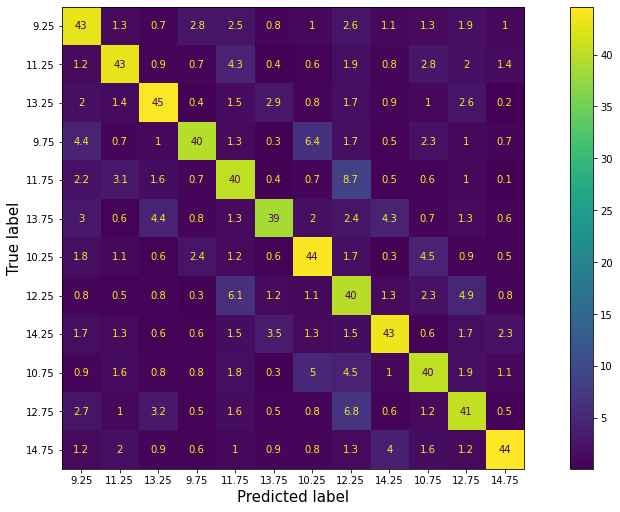

In [25]:
#Generate Confusion Matrix to evaluate performance
cm = np.mean(np.array(cm_list),axis=0)
freq_labels = np.array(['9.25','11.25','13.25','9.75','11.75','13.75','10.25','12.25','14.25','10.75','12.75','14.75'])
disp_cm = ConfusionMatrixDisplay(cm,display_labels=freq_labels)
fig, ax = plt.subplots()
fig.set_size_inches(16.5, 8.5)
ax.set_xlabel("Predicted Label", fontsize = 15)
ax.set_ylabel("True Label", fontsize = 15)

disp_cm.plot(ax=ax)

In [26]:
#Evaluation CCA Accuracy
CCA_acc = []
for i in range(1,11):
  np.random.seed(1)
  X_train,X_test,y_train,y_test = eeg_loader_loo('/content/drive/MyDrive/Colab Notebooks/SSVEP_CNN_Project/cca_ssvep/',f's{i}',fmin=9,fmax=30,visualize=False,num_wind=4)
  X_train = X_train.transpose(0,2,1)
  X_test = X_test.transpose(0,2,1)
  CCA_preds = CCA_accuracy_assess(X_test,y_test)
  CCA_preds = CCA_preds + 1 #Shift by one to match the actual labels assigned in CCA_accuracy_assess
  CCA_acc.append(np.sum(CCA_preds == y_test)/len(y_test))
print("Accuracy: ",CCA_acc)

Accuracy:  [0.30416666666666664, 0.2638888888888889, 0.5166666666666667, 0.7013888888888888, 0.5319444444444444, 0.8888888888888888, 0.6916666666666667, 0.875, 0.5958333333333333, 0.5958333333333333]


<Figure size 432x288 with 0 Axes>

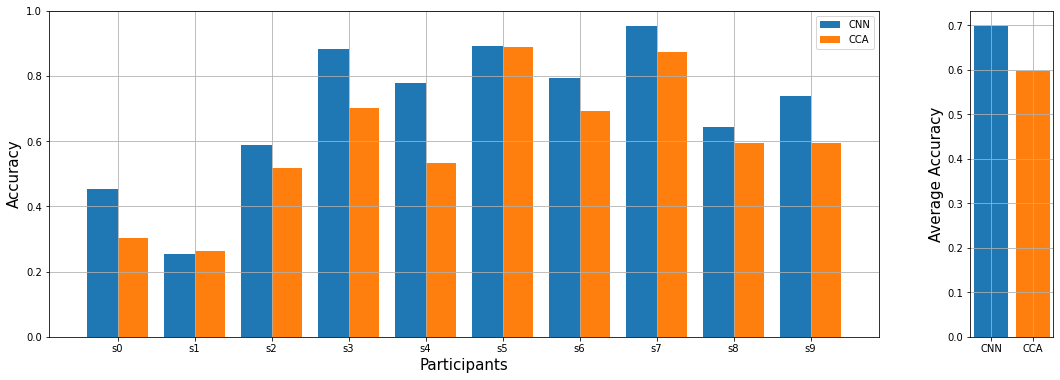

In [27]:
#Plot to compare our CNN to CCA
import matplotlib as mpl
mpl.rc('image', cmap='veridis')
mpl.pyplot.viridis()

X = [f's{i}' for i in range(len(CCA_acc))]
YNet = SSVEPNet_acc
Zcca = CCA_acc

fig, ax = plt.subplots(1,2, figsize=(18,6),gridspec_kw={'width_ratios': [10, 1]})

X_axis = np.arange(len(X))

ax[0].set_xticks(X_axis)
ax[0].set_xticklabels(X)

ax[0].bar(X_axis - 0.2, YNet, 0.4, label = 'CNN')
ax[0].bar(X_axis + 0.2, Zcca, 0.4, label = 'CCA')
ax[0].set_xlabel("Participants",fontsize=15)
ax[0].set_ylabel("Accuracy",fontsize=15)
ax[0].legend()
ax[0].grid()

meanY = np.mean(YNet)
meanZ = np.mean(Zcca)
stdY = np.std(YNet)
stdZ = np.std(Zcca)

ax[1].bar([0],[meanY])
ax[1].bar([1],[meanZ])
ax[1].set_xticks([0,1])
ax[1].set_xticklabels(["CNN","CCA"])
ax[1].set_ylabel("Average Accuracy",fontsize=15)
ax[1].grid()

### Gradient Ascent All Netowrks Implementation:
Peforms gradient ascent (EEGDream) on gaussian noise input using all the networks (which were trained on user s{i} left out during training). The power spectral density of the signal resulting from gradient ascent is analyzed for later averaging and plotting.

In [28]:
#Run gradient ascent on all networks
psd_per_network = []
Filtering = False
plot_rand_signal = False
measure_CCA = True
cum_corr = []
for i in range(1,11):
  #Load Model Trained on user i left out
  current_subject = f"s{i}"
  Load_SSVEP_Model = keras.models.load_model(f'/content/drive/MyDrive/School/MIT Fall2021/9.58/SSVEPNet_Colab/one_sec_windows_model_7to30/keras_normalized_model_kernel_{current_subject}/')

  #Define model to run gradient ascent on:
  output_layer = Load_SSVEP_Model.get_layer(index=-1).output
  ascent_model = tf.keras.Model(inputs=Load_SSVEP_Model.input, outputs=output_layer)

  #Initialize EEGDream, the gradient ascent model
  eegdream = EEGDream(ascent_model)

  # Generate random Gaussian noise. Set random seed to 0 to keep 
  #input noise signal invariant across users
  np.random.seed(0)
  eeg= np.random.normal(loc=0,scale=1,size=(1,8,256)) #Generate signal
  if Filtering:
    eeg= butter_bandpass_filter(eeg,3,30, fs=256, order=2)
  eeg= norm_stand_data(eeg) #normalize
  eeg_plot = eeg[0,:,:]
  if plot_rand_signal:
    plt.figure()
    plt.plot(eeg_plot.T)
    df_freq ,df_psd = welch(eeg_plot,fs=256)
    plt.figure()
    plt.plot(df_freq,df_psd.T)
    plt.xlim([7,60])
  
  #Run Gradient ascent on simulated SSVEP signal:
  converted_eeg = eeg.transpose(0,2,1)
  grad_ascent_SSVEP = []
  for freq in range(12):
    eeg_transformed = run_eeg_dream_simple(converted_eeg,neuron_idx=freq)
    # print(eeg_transformed.shape)
    grad_ascent_SSVEP.append(eeg_transformed.numpy().transpose(0,2,1))
  
  if measure_CCA:
    corr_list = []
    for sim_eeg in grad_ascent_SSVEP:
      eeg_filt= butter_bandpass_filter(sim_eeg,7,60, fs=256, order=2)
      corr = CCA_accuracy_assess(eeg_filt,[i for i in range(12)],full_output=True)
      # print("Correlations: ",corr)
      # acc = np.sum(np.array(np.argmax(corr)) == np.array([i for i in range(12)]))/len(corr)
      # print("Accuracy: ", acc)
      corr_list.append(corr)
    cum_corr.append(np.array(corr_list))

  #Compute Power Spectral Density
  stim_freq = {1:9.25,2:11.25,3:13.25,4:9.75,5:11.75,6:13.75,7:10.25,8:12.25,9:14.25,10:10.75,11:12.75,12:14.75}
  psd_all_chans = []
  for freq in range(1,len(grad_ascent_SSVEP)+1):
    eeg_plot = butter_bandpass_filter(grad_ascent_SSVEP[freq-1], 7, 60, fs=256, order=2)
    df_freq ,df_psd = welch(eeg_plot,fs=256)
    psd_all_chans.append(df_psd)
  psd_per_network.append(np.vstack(psd_all_chans))

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


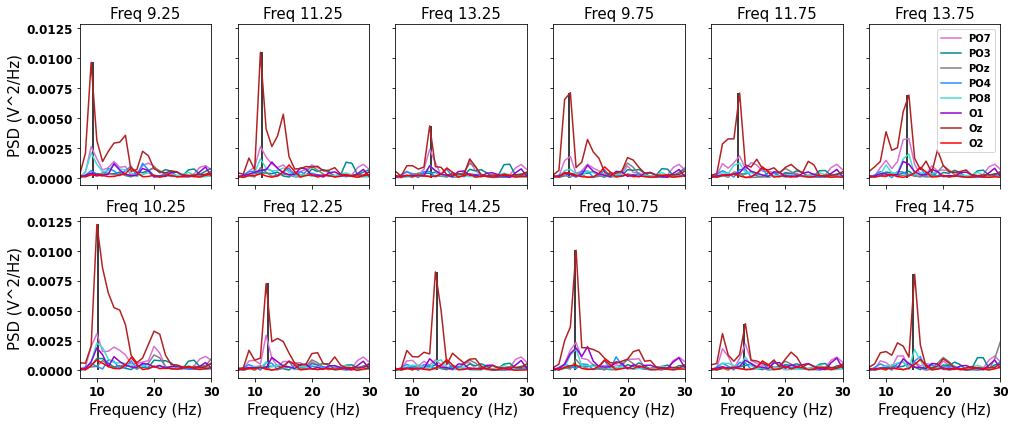

In [29]:
#Plot Average Power Spectrum per Target Frequency

psd_arr = np.array(psd_per_network)
mean_psd_arr = np.mean(psd_arr,axis=0)

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

#Specify Relevant Variables
stim_freq = {1:9.25,2:11.25,3:13.25,4:9.75,5:11.75,6:13.75,7:10.25,8:12.25,9:14.25,10:10.75,11:12.75,12:14.75}
chan_names = ["PO7","PO3","POz","PO4","PO8","O1","Oz","O2"]
chan_color = {0: u'orchid', 1: u'darkcyan', 2: u'grey', 3: u'dodgerblue', 4: u'turquoise', 5: u'darkviolet',6: u'firebrick',7:u'red'}

fig, ax = plt.subplots(2,6,sharex=True, sharey=True)

fig.set_size_inches(16.5,6.5)

fig_idx1, fig_idx2 = [0,-1]
for freq in range(1,13):
  fig_idx2 += 1
  df_psd = mean_psd_arr.squeeze()[freq-1,:,:]
  for i in range(df_psd.shape[0]):
    ax[fig_idx1,fig_idx2].plot(df_freq,df_psd[i,:],label=chan_names[i],color=chan_color[i])
  ax[fig_idx1,fig_idx2].vlines(float(stim_freq[freq]),ymin=np.min(df_psd), ymax=np.max(df_psd),colors='k')
  ax[fig_idx1,fig_idx2].set_xlim([7,30])
  if fig_idx1 == 0 and fig_idx2 == 5:
    ax[fig_idx1,fig_idx2].legend(fontsize=10)
  if fig_idx1 == 1:
    ax[fig_idx1,fig_idx2].set_xlabel("Frequency (Hz)",fontsize=15)
  if fig_idx1 == 0 and fig_idx2 == 0 or fig_idx1 == 1 and fig_idx2 == 0:
    ax[fig_idx1,fig_idx2].set_ylabel("PSD (V^2/Hz)",fontsize=15)
  ax[fig_idx1,fig_idx2].set_title(f'Freq {stim_freq[freq]}',fontsize=15)
  if fig_idx2 == 5:
    fig_idx2 = -1
    fig_idx1 = 1

Text(0, 0.5, 'Accuracy')

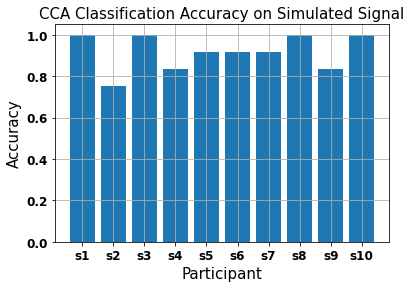

In [30]:
#Analyze Reconstructed SSVEP Signal using CCA
cum_corr_arr = np.array(cum_corr)
CCA_on_ascent = []
for i in range(10):
  stim_freq_list = [9.25, 11.25, 13.25, 9.75, 11.75, 13.75, 10.25, 12.25, 14.25, 10.75, 12.75, 14.75]
  acc = (np.sum(np.argmax(cum_corr_arr[i,:,:],axis=0) == np.array([i for i in range(12)]))/len(stim_freq_list))
  CCA_on_ascent.append(acc)

plt.figure()
plt.grid()
plt.bar([f's{i}' for i in range(1,11)],CCA_on_ascent)
plt.title("CCA Classification Accuracy on Simulated Signal",fontsize=15)
plt.xlabel("Participant",fontsize=15)
plt.ylabel("Accuracy",fontsize=15)

### Compute Loss Score by setting different channels to zero:

In [ ]:
#Evaluate Every LOO Netork and Compute the Loss Obtained when Specific Channels are turned off
All_losses = []
for i in range(1,11):
  current_subject = f"s{i}"
  np.random.seed(1)
  X_train,X_test,y_train,y_test = eeg_loader_loo('/content/drive/MyDrive/Colab Notebooks/SSVEP_CNN_Project/cca_ssvep/',f'{current_subject}',visualize=False, fmin=9,fmax=30,num_wind=4)
  Load_SSVEP_Model = keras.models.load_model(f'/content/drive/MyDrive/School/MIT Fall2021/9.58/SSVEPNet_Colab/one_sec_windows_model_7to30/keras_normalized_model_kernel_{current_subject}/')
  Loss_score = []
  Acc_score = []
  test_encoder = LabelEncoder()
  test_encoder.fit(y_test)
  test_encoded_Y = test_encoder.transform(y_test)
  y_test_encoded = np_utils.to_categorical(test_encoded_Y)
  for i in range(8):
    Mod_X = X_test.copy()
    Mod_X[:,:,i] = 0
    loss,acc = Load_SSVEP_Model.evaluate(Mod_X,y_test_encoded)
    Loss_score.append(loss)
    Acc_score.append(acc)
  All_losses.append(Loss_score)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


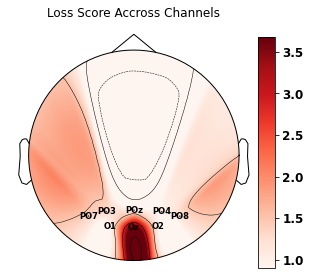

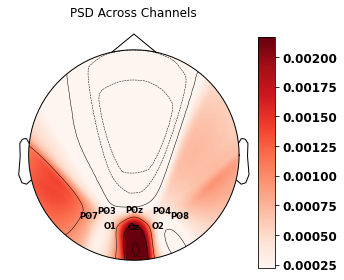

In [32]:
#Plott mean PSD as well as mean Loss Score
mean_loss_drop = np.mean(np.array(All_losses),axis=0)
mean_loss_drop = np.array(Loss_score)
psd_headplotter(mean_loss_drop)
all_data = np.vstack((X_train,X_test))

f, psd = signal.welch(all_data[:,:,:].transpose(0,2,1), fs=256)
avg_psd = np.mean(mean_psd_arr[:,:,(f>7)==(f<20)],axis=0)
avg_psd = np.mean(avg_psd,axis=1)

psd_headplotter(avg_psd,"PSD Across Channels")